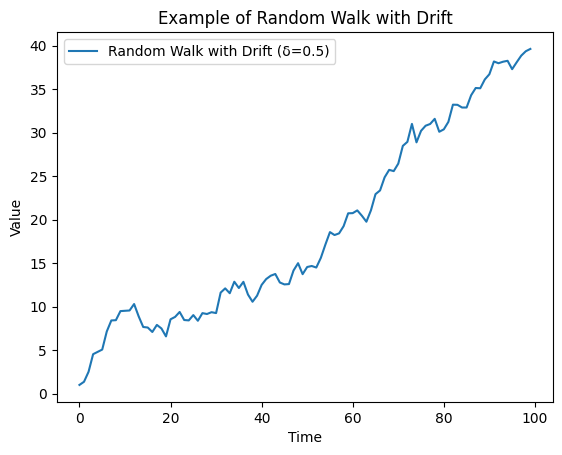

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

n = 100
drift = 0.5   # upward push
noise = np.random.normal(0, 1, n)  # white noise
y = np.cumsum(drift + noise)  # cumulative sum builds random walk with drift

plt.plot(y, label="Random Walk with Drift (δ=0.5)")
plt.title("Example of Random Walk with Drift")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

ADF on original series:
  ADF statistic: 0.517, p-value: 0.985

ADF on first-differenced series:
  ADF statistic: -4.494, p-value: 0.000


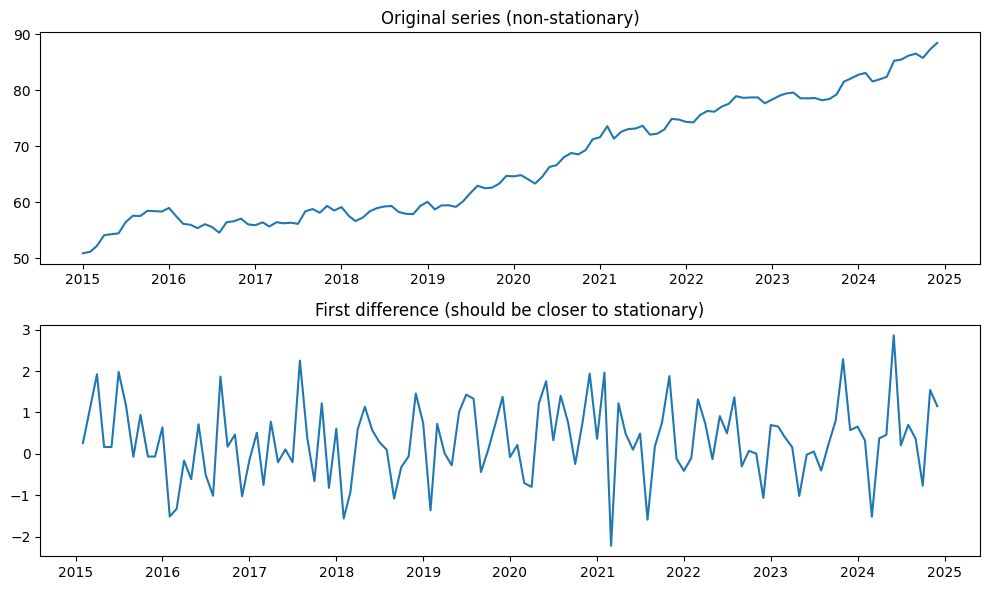

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
np.random.seed(42)
n = 120  # 10 years of monthly data
dates = pd.date_range('2015-01-01', periods=n, freq='MS')

# Random walk with small drift -> needs differencing (d=1)
noise = np.random.normal(0, 1.0, size=n)
y = 50 + np.cumsum(0.4 + noise)  # level 50, drift 0.4, plus noise
ts = pd.Series(y, index=dates, name='value')

# --- 2) Check stationarity, difference, and visualize
print("ADF on original series:")
adf_stat, pval, *_ = adfuller(ts)
print(f"  ADF statistic: {adf_stat:.3f}, p-value: {pval:.3f}")

ts_diff = ts.diff().dropna()

print("\nADF on first-differenced series:")
adf_stat_d, pval_d, *_ = adfuller(ts_diff)
print(f"  ADF statistic: {adf_stat_d:.3f}, p-value: {pval_d:.3f}")

fig, axes = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True)
axes[0].plot(ts); axes[0].set_title("Original series (non-stationary)")
axes[1].plot(ts_diff); axes[1].set_title("First difference (should be closer to stationary)")
plt.show()

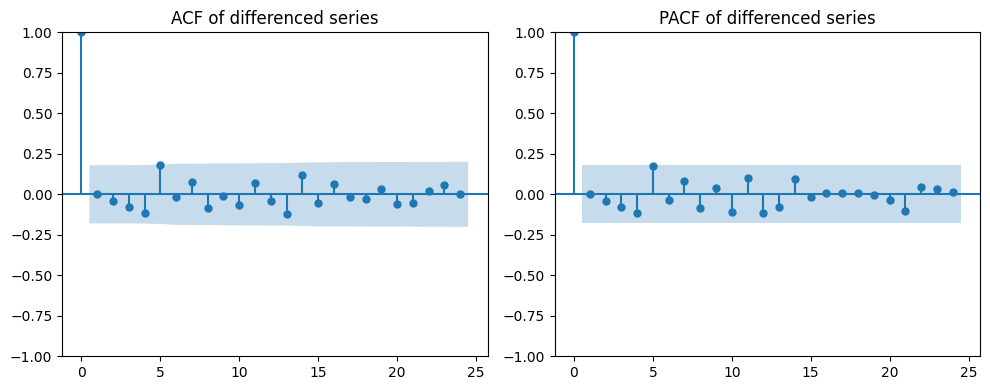

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
plot_acf(ts_diff, ax=axes[0], lags=24)
axes[0].set_title("ACF of differenced series")
plot_pacf(ts_diff, ax=axes[1], lags=24, method='ywm')
axes[1].set_title("PACF of differenced series")
plt.show()

In [4]:
from statsmodels.tsa.arima.model import ARIMA
# --- 4) Fit an ARIMA(p,d,q) on the ORIGINAL series (model handles differencing internally)
# We'll choose (p,d,q) = (1,1,1) as a reasonable starting point for a drifted random walk.
model = ARIMA(ts, order=(1, 1, 1))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -161.236
Date:                Wed, 22 Oct 2025   AIC                            328.473
Time:                        17:06:19   BIC                            336.810
Sample:                    01-01-2015   HQIC                           331.858
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.007    142.110      0.000       0.986       1.014
ma.L1         -0.9985      0.507     -1.969      0.049      -1.992      -0.005
sigma2         0.8621      0.442      1.952      0.0

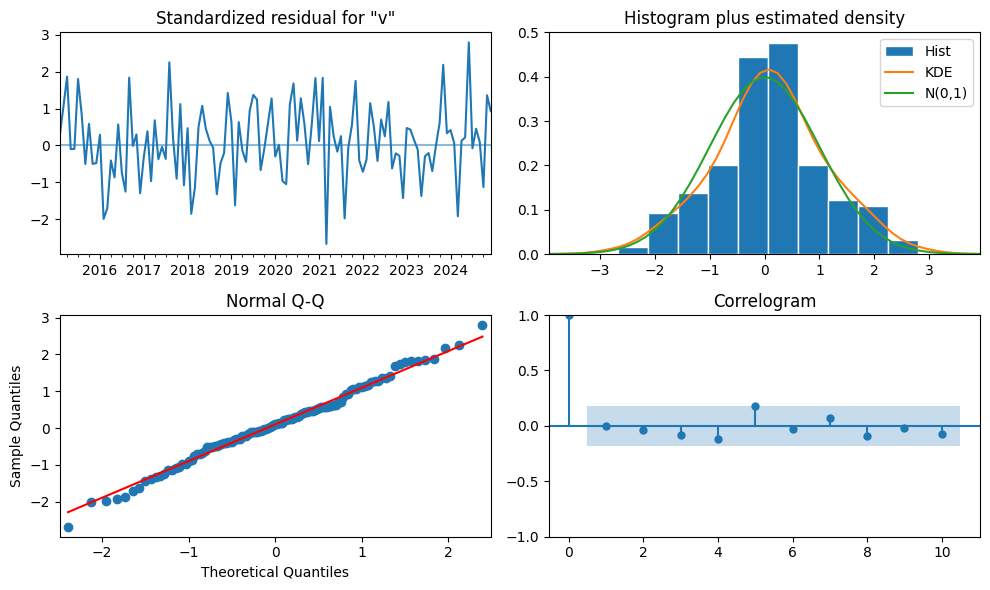

In [5]:
#Quick diagnostics (residuals should look like white noise)
res.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()

XGBoost Practice

c:\Users\najmu\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:06:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuray: 0.9

Classification Report: 
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



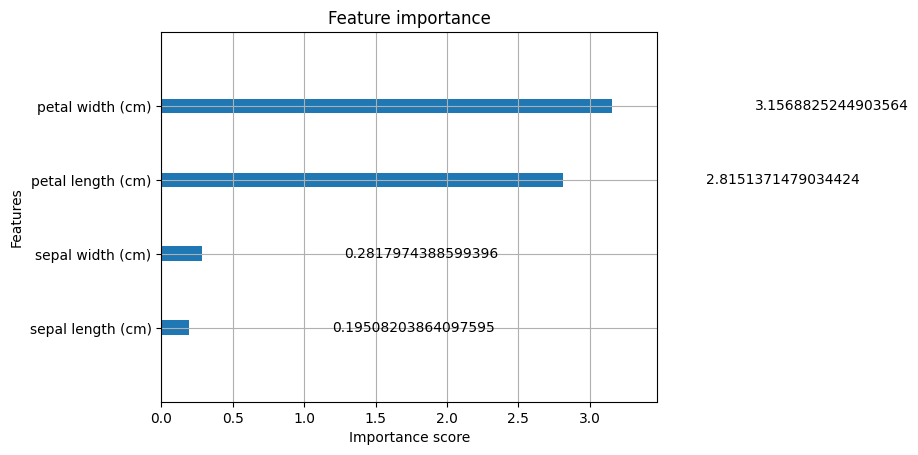

In [6]:
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

iris= load_iris()
X, Y= iris.data, iris.target

x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model= xgb.XGBClassifier(
    n_estimators= 100,
    learning_rate= 0.1,
    max_depth= 3,
    subsample= 0.8,
    colsample_bytree= 0.8,
    gamma= 0,
    reg_lambda=1,
    reg_alpha= 0,
    random_state= 42,
    use_label_encoder= False,
    eval_metric= "mlogloss"
)

model.fit(x_train, y_train)
y_pred= model.predict(x_test)

print("Accuray:", accuracy_score(y_test, y_pred))
print("\nClassification Report: \n",classification_report(y_test, y_pred, target_names=iris.target_names))

ax= xgb.plot_importance(model, importance_type='gain')
ax.set_yticklabels(iris.feature_names) #to get the original feature names
import matplotlib.pyplot as plt
plt.show()

In [7]:
import pandas as pd
df= pd.DataFrame(X, columns=iris.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Time Series analysis practice with machine learning model(xgboost)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [9]:
df= pd.read_csv("PJME_hourly.csv") #popular dataset containing hourly electricity demand from the PJM Energy Market (Eastern USA).
df.head()


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [11]:
df= df.set_index('Datetime') #set datetime col into index
df.index= pd.to_datetime(df.index) #convert datetime index to datetime format from object

In [12]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [13]:
import seaborn as sns
color_pal= sns.color_palette() #Gets the default Seaborn color palette
color_pal 

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [14]:
print(color_pal, 2) #Returns a list of RGB color tuples
#(Blue), (Orange), (Green), ... color codes

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)] 2


In [15]:
color_pal[1] # Second color (orange)

(1.0, 0.4980392156862745, 0.054901960784313725)

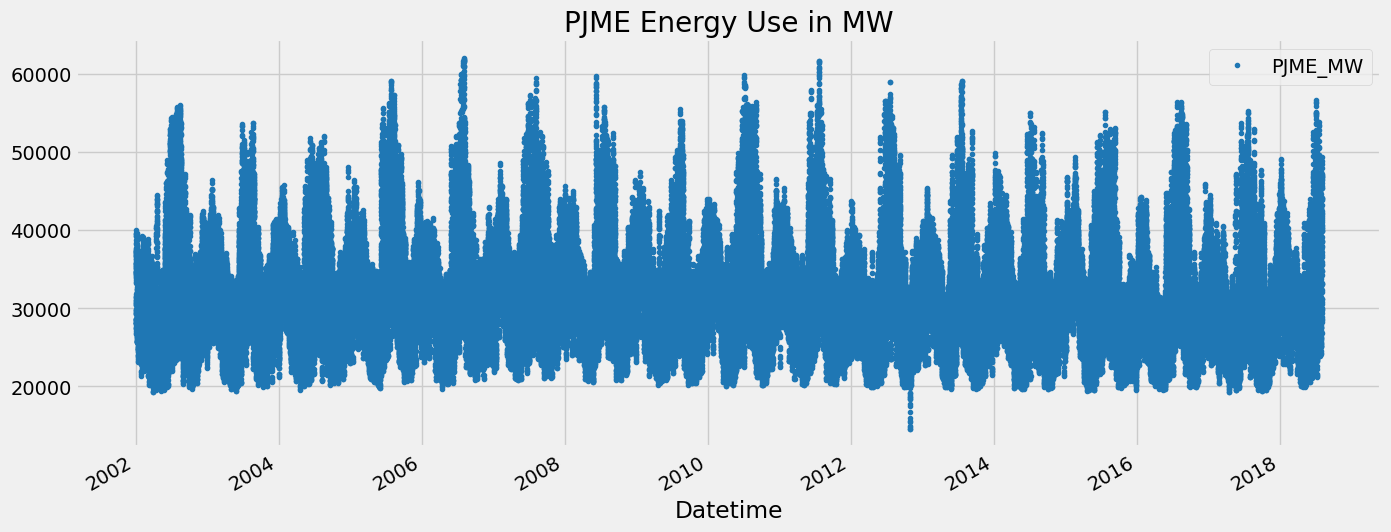

In [16]:
plt.style.use('fivethirtyeight') #Applies a predefined style theme to all subsequent plots
#'fivethirtyeight' mimics the style of FiveThirtyEight.com (data journalism website)
df.plot(style='.',
        figsize=(15,6),
        color= color_pal[0],
        title='PJME Energy Use in MW') #plotting the original dataset nature
plt.show()

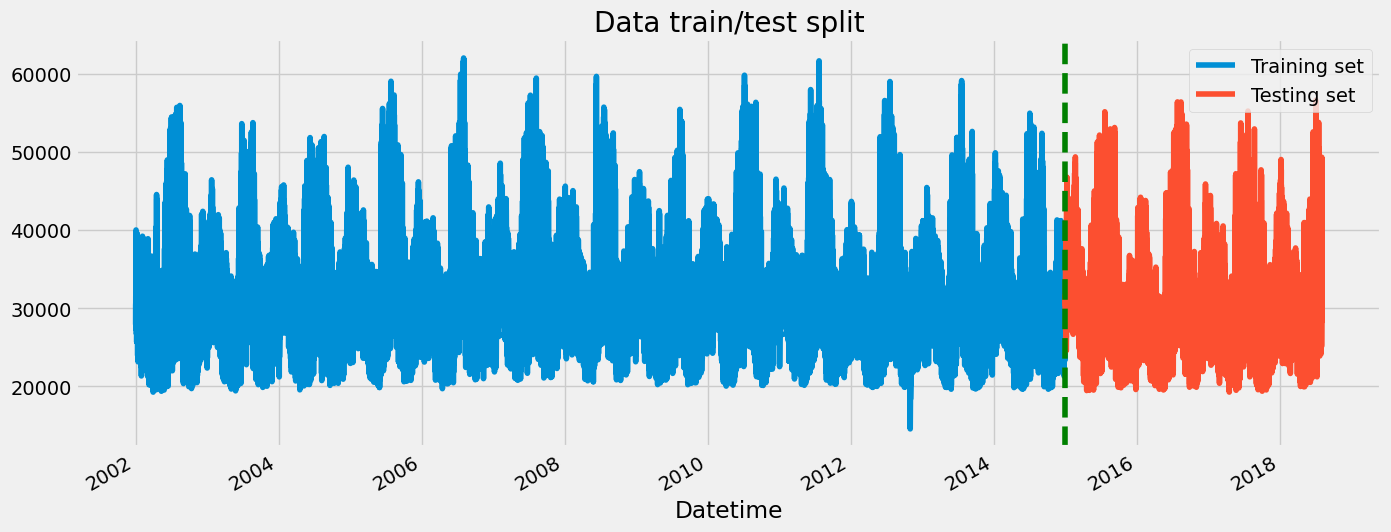

In [17]:
#split train and testing data and plot them
train= df.loc[df.index < '01-01-2015']
test= df.loc[df.index >= '01-01-2015']

fig, ax= plt.subplots(figsize=(15,6))
train.plot(ax=ax, label='Train dataset', title='Data train/test split')
test.plot(ax=ax, label='Test dataset') #Plots both training and test data on the same axes
# Both series appear on one plot with different colors
ax.axvline(x='01-01-2015',color='green', ls='--') #'ax.axvline()'used to add a vertical line at apoint of x-axis across the axes of a plot.
ax.legend(['Training set', 'Testing set'])
plt.show()

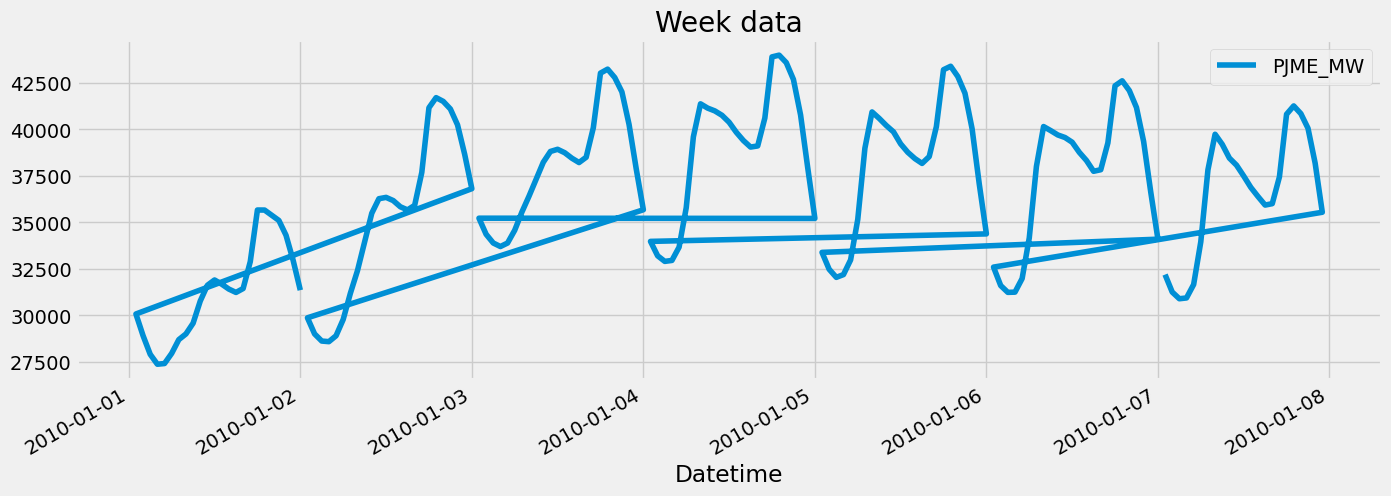

In [18]:
#to show the data structure by filtering and plotting a specific week of data from middle(like zooming a portion of data)
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]\
.plot(figsize=(15,5), title='Week data') # '\' at the end of a line indicates that the statement continues on the next line.(When a line of code becomes very long and want to break it into multiple lines for readability)
plt.show()

In [19]:
#resample the data(upsampling) to ensure it is continious
df_resampled= df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].resample('h').mean()
#handling missinf values with 'ffill'(forward fill)
df_resampled= df_resampled.ffill()

missing_values= df_resampled.isnull().sum()
print(f'missing values:\n{missing_values}')

missing values:
PJME_MW    0
dtype: int64


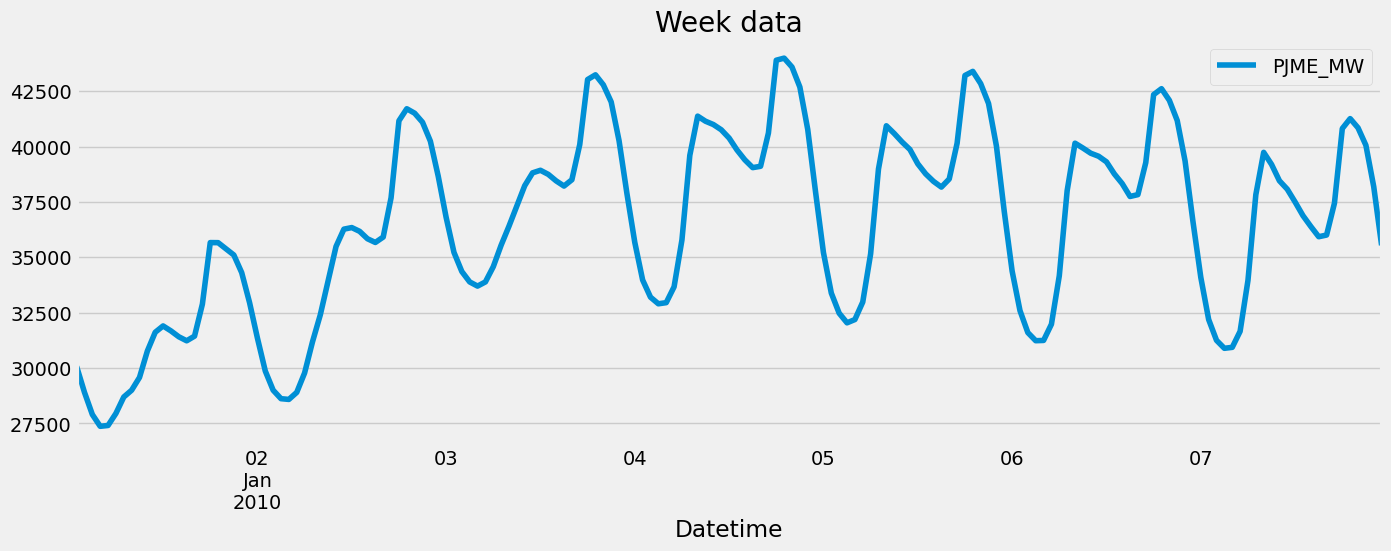

In [20]:
df_resampled.plot(figsize=(15,5), title='Week data')
plt.show()

In [21]:
def create_features(df):
    """
    Create time series features based on date-time index
    """
    df= df.copy() #Good practice to avoid unintended side effects
    df['hour']= df.index.hour
    df['dayofweek']= df.index.dayofweek
    df['month']= df.index.month
    df['quarter']= df.index.quarter
    df['year']= df.index.year
    df['dayofyear']= df.index.dayofyear
    df['dayofmonth']= df.index.day
    df['weekofyear']= df.index.isocalendar().week
    return df
df= create_features(df)
df.head()


,PJME_MW,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,4,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,12,4,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,12,4,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,12,4,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,12,4,2002,365,31,1


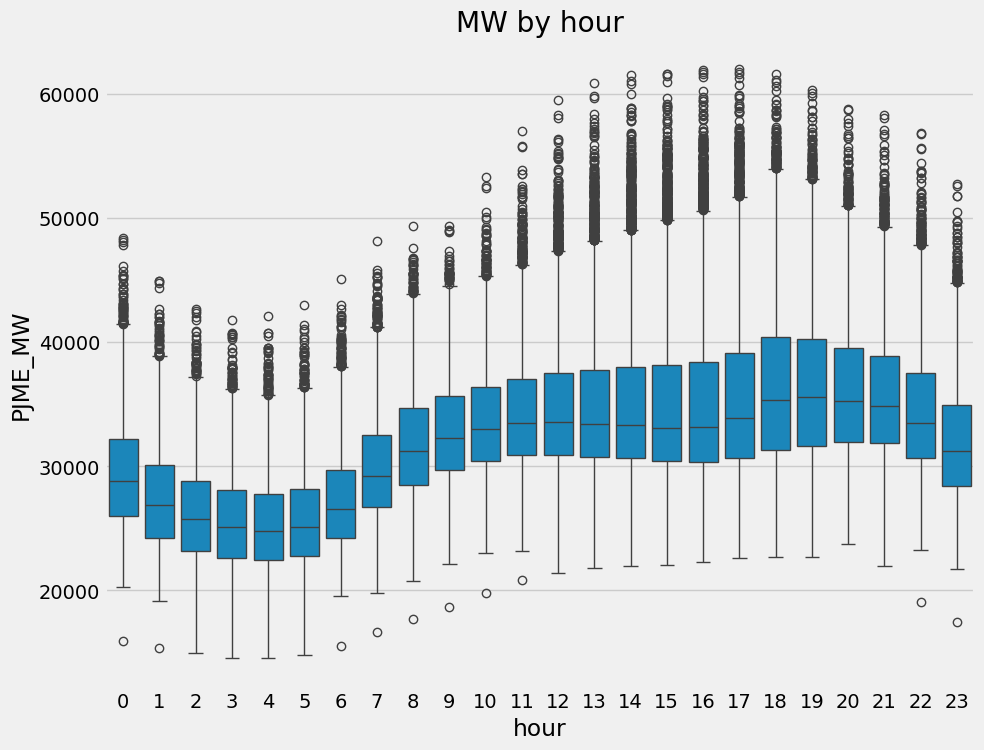

In [22]:
fig, ax= plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by hour')
plt.show()

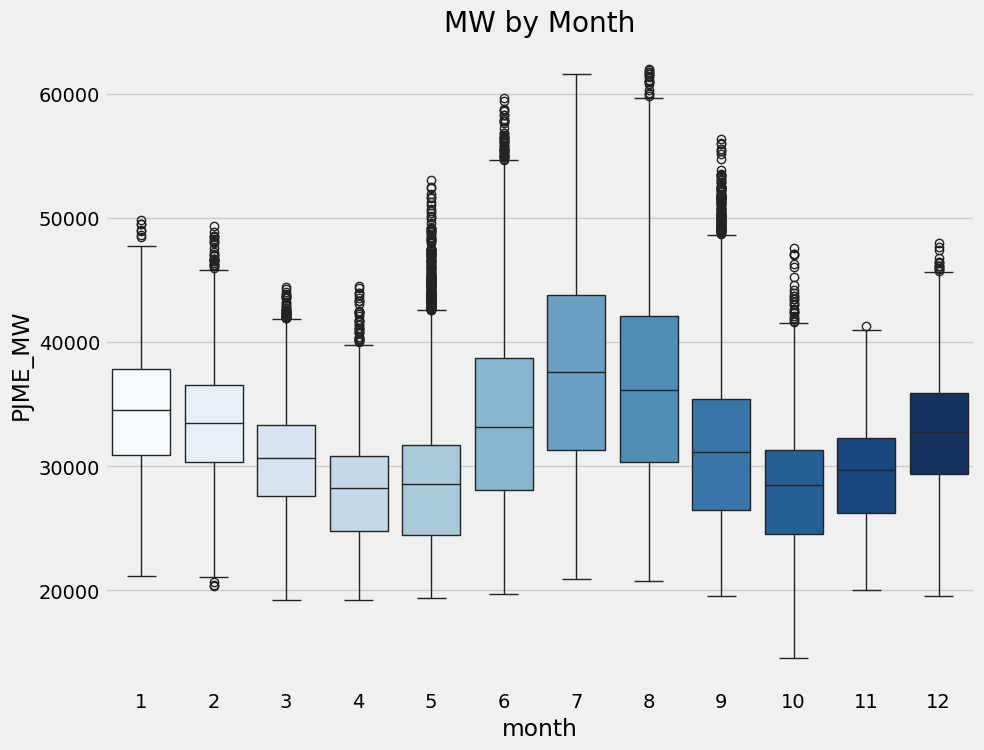

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', hue='month', palette='Blues', legend=False)
ax.set_title('MW by Month')
plt.show()

In [24]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_Train = train[FEATURES]
y_Train = train[TARGET]

X_Test = test[FEATURES]
y_Test = test[TARGET]

In [25]:
reg= xgb.XGBRegressor(base_score= 0.5,booster='gbtree',
                    n_estimators= 1000, early_stopping_rounds= 50, #to see improvements in 'rmse' for training and test dataset after 50 rounds consecutively, use 'early_stopping_rounds' 
                    objective= 'reg:squarederror', #for defining loss function('squared error' in this case)
                    max_depth= 3, learning_rate= 0.01)
reg.fit(X_Train, y_Train,
        eval_set=[(X_Train, y_Train), (X_Test, y_Test)],
        verbose= 100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [26]:
reg.feature_names_in_

array(['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year'],
      dtype='<U9')

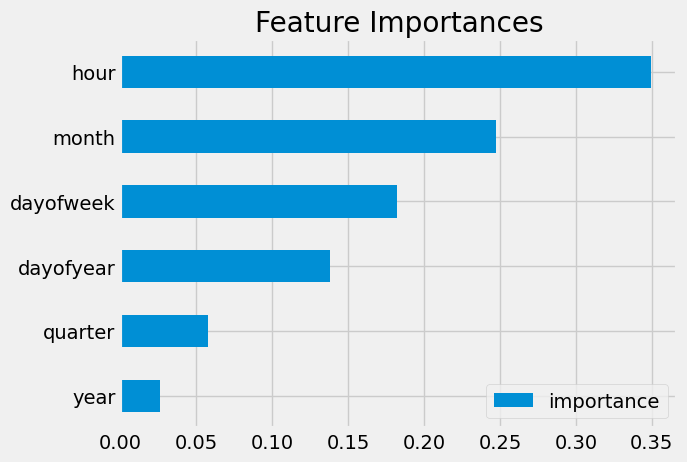

In [27]:
fi= pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,
                 columns=['importance'])
fi.sort_values('importance').plot(kind='barh',title='Feature Importances')
plt.show()

In [28]:
test['prediction']= reg.predict(X_Test)
test.head()

,PJME_MW,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1,30422.880859
2015-12-31 01:00:00,24305.0,1,3,12,4,2015,365,31,53,28121.423828
2015-12-31 02:00:00,23156.0,2,3,12,4,2015,365,31,53,27169.205078
2015-12-31 03:00:00,22514.0,3,3,12,4,2015,365,31,53,26777.427734
2015-12-31 04:00:00,22330.0,4,3,12,4,2015,365,31,53,26777.427734


In [29]:
test[['prediction']].head()#The double brackets [[...]] return a DataFrame (not a Series)

,prediction
Datetime,
2015-01-01 00:00:00,30422.880859
2015-12-31 01:00:00,28121.423828
2015-12-31 02:00:00,27169.205078
2015-12-31 03:00:00,26777.427734
2015-12-31 04:00:00,26777.427734


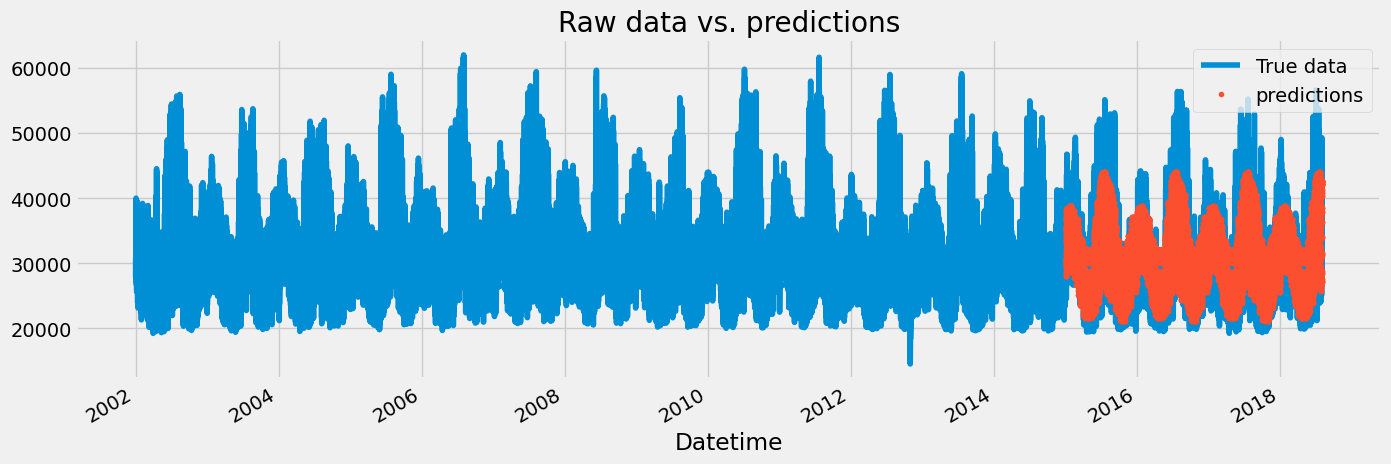

In [30]:
df=df.merge(test[['prediction']], how='left', left_index=True, right_index=True) #'[[]]' uses cause '.merge()' requires 2 dataframe(not any series)
#'left_index=True, right_index=True' uses to use datetime index (not a column) for merging
ax= df[['PJME_MW']].plot(figsize=(15,5)) #'[[]]' uses to take it's datetime index to put in x-axis(as it will be main plot)
#'ax'=>Stores the axes object, Allows us to add more plots on top
df['prediction'].plot(ax=ax, style='.') #plots just prediction values('[]' first bracket used) and overlayed on the same plot(ax=ax)
plt.legend(['True data', 'predictions'])
ax.set_title('Raw data vs. predictions')
plt.show()

In [31]:
df_resampled2= df.loc[(df.index>'4-01-2018')&(df.index<'4-08-2018')].resample('h').mean() #2018-04-02 00:00 → 2018-04-07 23:00 (168 rows)
#'resample('h')'Groups each hour, calculates mean (usually = original value if 1 per hour)

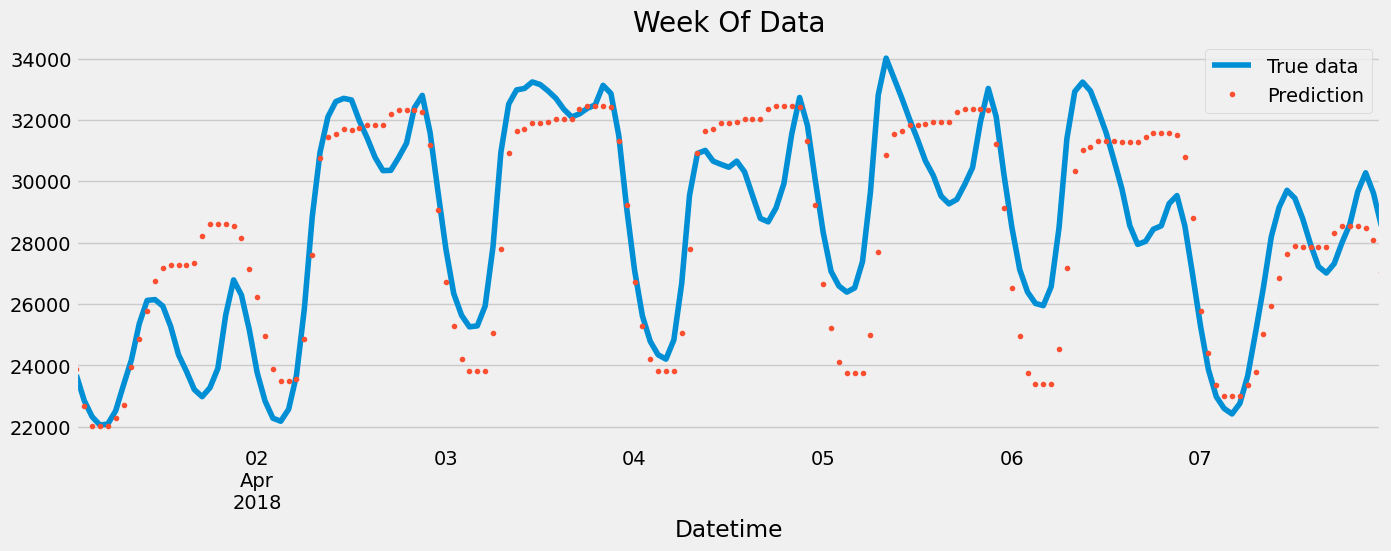

In [32]:
ax = df_resampled2.loc[(df_resampled2.index > '04-01-2018') & (df_resampled2.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data') #"\" used as line continuation character(for long line of code)
df_resampled2.loc[(df_resampled2.index>'04-01-2018')&(df_resampled2.index<'04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['True data', 'Prediction'])
plt.show()

In [33]:
score = mean_squared_error(test['PJME_MW'], test['prediction'])
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 13889027.66


In [34]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


In [35]:
test['error'] = np.abs(test[TARGET]-test['prediction'])
test['date']= test.index.date #to extract just the date part from the datetime index use '.date'
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10) #to see the top 10 worst-predicted days(as ordered in descending)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
Name: error, dtype: float64